### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import math
import pmdarima as pm

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore','statsmodels.tsa.ar_model.AR', FutureWarning)

from pandas.plotting import lag_plot,autocorrelation_plot
#from pylab import rcParams

from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg,ARResults
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


In [ ]:
df = pd.read_csv("Bike Rental UCI dataset.csv",parse_dates=['dteday'])

In [ ]:
df

## Exploratory Data Analysis

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.columns

### Drop unwanted features / Simplifying the Dataset

In [ ]:
df.drop(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday','weathersit','temp', 'atemp', 'hum', 'windspeed',
        'casual', 'registered'],axis=1,inplace=True)

In [ ]:
df.head()

In [ ]:
#df.to_csv("bikelite.csv",index=False)

In [ ]:
df = pd.read_csv("bikelite.csv", parse_dates=['dteday'])

In [ ]:
df.info()

In [ ]:
df2 = df.groupby('dteday').sum()
df2

In [ ]:
df2.reset_index(inplace=True)

In [ ]:
df2

In [ ]:
df2.shape

In [ ]:
#df2.to_csv("bikeseries.csv",index=False)

In [ ]:
df2.loc[0]

In [ ]:
df2.describe()

## Feature Engineering

In [ ]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'])

In [ ]:
df.head()

### Date time features

In [ ]:
df['year'] = df['dteday'].dt.year

In [ ]:
df['month'] = df['dteday'].dt.month

In [ ]:
df['day'] = df['dteday'].dt.day

In [ ]:
df.head()

### Lag Features

In [ ]:
df['lag1'] = df['dteday'].shift(1)

In [ ]:
df['lag2'] = df['dteday'].shift(365)

In [ ]:
df

### Window features

In [ ]:
df["roll_mean"] = df["cnt"].rolling(window=2).mean()

In [ ]:
df

In [ ]:
df["roll_max"] = df["cnt"].rolling(window=3).max()  #Previous 3 periods

In [ ]:
df

### Expanding features

In [ ]:
df['expand_max'] = df['cnt'].expanding().max()

In [ ]:
df

In [ ]:
#df.to_csv("bikefeature.csv",index=False)

## Time-Series Visualization

In [ ]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.info()

In [ ]:
df.index.freq = "D"

In [ ]:
df.head()

In [ ]:
df.plot(figsize=(30,10), title="Rental Bikes")
plt.ylabel("Count")
plt.show()

In [ ]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=df.index,y=df.cnt,data=df, estimator=None)
plt.xticks(rotation=90)
plt.title("Rental Bikes")
plt.ylabel("Count")
plt.show()

### Zooming in date range

In [ ]:
zoomjan = df[(df.index >= '2011-01-01') & (df.index <= '2011-01-31')]

In [ ]:
zoomjan

In [ ]:
zoomjan.plot(figsize=(30,10), title="Rental Bikes in January")
plt.ylabel("Count")
plt.show()

### Trendline

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(20,5))
sns.regplot(x=df.index.values, y=df['cnt'], order=1)
plt.show()

### Removing seasonality

In [ ]:
df['month'] = df['dteday'].dt.month

In [ ]:
df

In [ ]:
df.groupby('month')['cnt'].mean()

In [ ]:
df.groupby('month')['cnt'].mean().plot()
plt.show()

### Creating Lag plots

In [ ]:
df['lag1'] = df['cnt'].shift(1)

In [ ]:
df.head()

In [ ]:
sns.scatterplot(x=df.lag1,y=df.cnt,data=df)
plt.show()

In [ ]:
lag_plot(df['cnt'])
plt.show()

### Autocorrelation Plots

In [ ]:
plt.figure(figsize=(12,4))
autocorrelation_plot(df['cnt'])
plt.show()

## Downsampling and Upsampling

In [ ]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'])

In [ ]:
df.head()

### Downsampling

In [ ]:
quarterly_df = df.resample(rule='Q', on='dteday').sum()

In [ ]:
quarterly_df

In [ ]:
weekly_df = df.resample(rule='W', on='dteday').sum()

In [ ]:
weekly_df

## Decomposing Time Series

### Additive or Multiplication model

In [ ]:
decomp_df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col='dteday')

In [ ]:
decomp_df.index.freq = "D"

In [ ]:
decomp_df.head()

In [ ]:
result = seasonal_decompose(x=decomp_df['cnt'], model='additive')

In [ ]:
#plt.title("Additive Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result.plot()
plt.show()

In [ ]:
result2 = seasonal_decompose(x=decomp_df['cnt'], model='multiplicative')

In [ ]:
#plt.title("Multiplicative Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result2.plot()
plt.show()

## Convert Non-Stationary to Stationary

### Differencing Method

In [ ]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col="dteday")

In [ ]:
df.index.freq = "D"

In [ ]:
df.head()

In [ ]:
df["lag1"] = df['cnt'].shift(1)

In [ ]:
df["diff1"] = df['cnt'].diff(periods=1)

In [ ]:
df.head()

In [ ]:
result_a = seasonal_decompose(x=df["cnt"],model='additive')

In [ ]:
plt.rcParams['figure.figsize'] = (14,9)
result_a.plot()
plt.show()

In [ ]:
#Select diff1
result_b = seasonal_decompose(x=df.iloc[1:,2], model='additive')

In [ ]:
plt.rcParams['figure.figsize'] = (14,9)
result_b.plot()
plt.show()

In [ ]:
#Remove seasonal components
df["diff2"] = df['diff1'].diff(periods=1)

In [ ]:
df.head()

In [ ]:
df["diff2"].plot(figsize=(20,5))
plt.show()

In [ ]:
#Check diff2
result_c = seasonal_decompose(df.iloc[2:,3])

In [ ]:
plt.rcParams['figure.figsize'] = (14,9)
result_c.plot()
plt.show()

In [ ]:
#Seasonal First Difference
df["Seasonal First Difference"] = df["cnt"] - df["cnt"].shift(12)

In [ ]:
df.head(14)

In [ ]:
#Save as csv
#df.to_csv('cleaned.csv',index=True)

In [ ]:
df["Seasonal First Difference"].plot(figsize=(20,5))
plt.show()

In [ ]:
result_d = seasonal_decompose(df.iloc[12:,4])

In [ ]:
plt.rcParams['figure.figsize'] = (14,9)
result_d.plot()
plt.show()

In [ ]:
df.cnt.plot(legend=True,figsize=(20,5))
df.lag1.plot(legend=True)
df.diff1.plot(legend=True)
df.diff2.plot(legend=True, color='blue', alpha=0.3)
plt.show()

In [ ]:
#Autocorrelation Plot
plt.rcParams['figure.figsize'] = (12,4)
autocorrelation_plot(df["Seasonal First Difference"].dropna())
plt.show()

## Stationarity Tests

In [ ]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col="dteday")

In [ ]:
df.index.freq = "D"

In [ ]:
df.head()

In [ ]:
adfuller(df.cnt)

In [ ]:
dftest = adfuller(df['cnt'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
print(dfout)

Result: Fail to reject null hypothesis and data is non-stationary

In [ ]:
print("ADF Test for Diff1")

dftest = adfuller(df.iloc[1:,2])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
print(dfout)

In [ ]:
print("ADF Test for Diff2")

dftest = adfuller(df.iloc[2:,3])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
dfout

In [ ]:
adfuller(df["Seasonal First Difference"].dropna())

In [ ]:
print("ADF Test for Seasonal First Difference")

dftest = adfuller(df["Seasonal First Difference"].dropna())
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
dfout

## ACF

In [ ]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'])

In [ ]:
plt.rcParams['figure.figsize'] = (14,5)
sgt.plot_acf(df.cnt, lags=40)
plt.title("Autocorrelation Plot")
plt.show()

Looking at the ACF plot, we only see a significant peak at lag 1, suggesting a non-seasonal MA(1) process.

## PACF

In [ ]:
plt.rcParams['figure.figsize'] = (14,5)
sgt.plot_pacf(df.cnt, lags=40, method='ols')
plt.title("PACF Plot")
plt.show()

We can see from the PACF that we have a significant peak at lag 1, which suggest an AR(1) process. Also, we have another peak at lag 6, suggesting a seasonal autoregressive process of order 1 (P = 1)

## Train-Test Split

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.index.freq = "D"

In [ ]:
df.head()

In [ ]:
len(df)

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train

In [ ]:
test

In [ ]:
train.shape, test.shape

## Time-series modeling

### Holt Winters Method

In [ ]:
fitted_model = ExponentialSmoothing(endog=train["cnt"], trend="additive",seasonal="additive", 
                                    seasonal_periods=12).fit()

In [ ]:
hwpred = fitted_model.forecast(30)

In [ ]:
hwpred

In [ ]:
test_data = test[:30]

In [ ]:
test_data

In [ ]:
train['cnt'].plot(legend=True,label="TRAIN",figsize=(16,5))
test['cnt'].plot(legend=True,label="TEST")
hwpred.plot(legend=True,label="PREDICTION")
plt.show()

In [ ]:
#Zoom into selected time frame
train['cnt'].plot(legend=True,label="TRAIN",figsize=(16,5))
test['cnt'].plot(legend=True,label="TEST")
hwpred.plot(legend=True,label="PREDICTION",xlim=['2012-08-07','2012-09-05'])
plt.show()

In [ ]:
test.describe()

In [ ]:
mse = mean_squared_error(test_data,hwpred)
mse

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data,hwpred))
rmse

In [ ]:
fitted_model2 = ExponentialSmoothing(endog=train["cnt"], trend="multiplicative",seasonal="multiplicative", 
                                    seasonal_periods=12).fit()

In [ ]:
hwpred2 = fitted_model2.forecast(30)

In [ ]:
hwpred2

In [ ]:
test_data = test[:30]

In [ ]:
test_data

In [ ]:
train['cnt'].plot(legend=True,label="TRAIN",figsize=(16,5))
test['cnt'].plot(legend=True,label="TEST")
hwpred2.plot(legend=True,label="PREDICTION2")
plt.show()

In [ ]:
mse = mean_squared_error(test_data,hwpred2)
mse

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data,hwpred2))
rmse

### Naive(Persistence Model)

In [ ]:
df = pd.read_csv("cleaned.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.index.freq = "D"

In [ ]:
df.head()

In [ ]:
df['t'] = df["cnt"].shift(1)

In [ ]:
df.head()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train

In [ ]:
train = train[1:]

In [ ]:
train

In [ ]:
test

In [ ]:
train.shape, test.shape

In [ ]:
train_X, train_y = train['t'], train["cnt"]
test_X, test_y = test['t'], test["cnt"]

In [ ]:
predictions = test_X.copy()

In [ ]:
print(predictions)
print(test_y)

### Naive Model Evaluation

In [ ]:
mse = mean_squared_error(test_y,predictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_y)
plt.plot(predictions)
plt.legend(["test_y","predictions"])
plt.title("Comparison of Real Test versus Predictions")
plt.show()

### Autoregression Model

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df = pd.read_csv("cleaned.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.head()

In [ ]:
df.index.freq ='D'

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train.shape, test.shape

In [ ]:
armodel = AutoReg(endog=train['cnt'],lags=1,trend='c',seasonal=False)

In [ ]:
armodel_fit = armodel.fit()

In [ ]:
armodel_fit.params

In [ ]:
armodel_fit.summary()

In [ ]:
arpredictions = armodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions

In [ ]:
print(test['cnt'])

In [ ]:
mse = mean_squared_error(test, arpredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions)
plt.legend(["test","AR Predictions"])
plt.title("Test and AR Predictions Graph")
plt.show()

In [ ]:
test["cnt"].plot(legend=True, figsize=(20,5))
arpredictions.plot(legend=True)
plt.title("Test and AR Predictions Graph")
plt.show()

### Method 2

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.head()

In [ ]:
df.index.freq ='D'

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.iloc[:size]

In [ ]:
test = df.iloc[size:]

In [ ]:
train.shape, test.shape

In [ ]:
armodel = ARMA(train["cnt"],order=(1,0))

In [ ]:
armodel_fit = armodel.fit()

In [ ]:
armodel_fit.params

In [ ]:
armodel_fit.summary()

In [ ]:
arpredictions = armodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions

In [ ]:
print(test['cnt'])

In [ ]:
mse = mean_squared_error(test, arpredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions)
plt.legend(["test","AR1 Predictions"])
plt.title("Test and AR1 Predictions Graph")
plt.show()

In [ ]:
test["cnt"].plot(legend=True, figsize=(20,5))
arpredictions.plot(legend=True)
plt.title("Test and AR1 Predictions Graph")
plt.show()

### AR2 Model -  Method 1

In [ ]:
armodel2 = AutoReg(endog=train['cnt'],lags=2)

In [ ]:
armodel2_fit = armodel2.fit()

In [ ]:
armodel2_fit.params

In [ ]:
armodel2_fit.summary()

In [ ]:
arpredictions2 = armodel2_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions2

In [ ]:
print(test)

In [ ]:
mse = mean_squared_error(test, arpredictions2)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions2)
plt.legend(["Test","AR2 Predictions"])
plt.title("Test and AR2 Predictions Graph")
plt.show()

In [ ]:
test.plot(legend=True, figsize=(20,5))
arpredictions2.plot(legend=True)
plt.title("Test and AR2 Predictions Graph")
plt.show()

### Method 2

In [ ]:
armodel2 = ARMA(endog=train['cnt'],order=(2,0))

In [ ]:
armodel2_fit = armodel2.fit()

In [ ]:
armodel2_fit.params

In [ ]:
armodel2_fit.summary()

In [ ]:
arpredictions2 = armodel2_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
arpredictions2

In [ ]:
print(test)

In [ ]:
mse = mean_squared_error(test, arpredictions2)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.cnt)
plt.plot(arpredictions2)
plt.legend(["Test","AR2 Predictions"])
plt.title("Test and AR2 Predictions Graph")
plt.show()

In [ ]:
test.plot(legend=True, figsize=(20,5))
arpredictions2.plot(legend=True)
plt.title("Test and AR2 Predictions Graph")
plt.show()

You can increase AR order value to see the summary table for significance level

### Use T-statistics

In [ ]:
ARfit = armodel.fit(use_t=True)

In [ ]:
ARfit.params

In [ ]:
ARfit.summary()

### Moving Average Model

### Method 1

In [2]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [3]:
df.index.freq ='D'

In [ ]:
df['t'] = df['cnt'].shift(1)

In [ ]:
df['residual'] = df['cnt'] - df['t']

In [ ]:
df.head()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train = df.residual[1:size]
test = df.residual[size:]

In [ ]:
train.head(), test.head()

In [ ]:
mavgmodel = AutoReg(train, lags=0)

In [ ]:
mavgmodel_fit = mavgmodel.fit()

In [ ]:
mavgmodel_fit.params

In [ ]:
mavgmodel_fit.summary()

In [ ]:
res_predictions = mavgmodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
res_predictions

In [ ]:
df.t[size:]

In [ ]:
predictions = df.t[size:] + res_predictions

In [ ]:
predictions

In [ ]:
test_y = df.cnt[size:]

In [ ]:
test_y

In [ ]:
mse = mean_squared_error(test_y, predictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test_y)
plt.plot(predictions)
plt.legend(["Test","MA Predictions"])
plt.title("Test and Moving Average Predictions Graph")
plt.show()

### Method 2

In [ ]:
mavgmodel = ARMA(endog=train.cnt,order=(0,1))

In [ ]:
mavgmodel_fit = mavgmodel.fit()

In [ ]:
mavgmodel_fit.params

In [ ]:
mavgmodel_fit.summary()

In [ ]:
mavg_predictions = mavgmodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [ ]:
mavg_predictions

In [ ]:
[test]

In [ ]:
mse = mean_squared_error(test, mavg_predictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(mavg_predictions)
plt.legend(["Test","MA Predictions"])
plt.title("Test and Moving Average Predictions Graph")
plt.show()

You can increase MA order value to see the summary table for significance level

### ARMA Model

In [4]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB


In [6]:
df.index.freq ='D'

In [7]:
df['cnt'] = df['cnt'].astype('float64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cnt     731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [9]:
df.index.freq ='D'

In [10]:
df.head()

,cnt
dteday,
2011-01-01,985.0
2011-01-02,801.0
2011-01-03,1349.0
2011-01-04,1562.0
2011-01-05,1600.0


In [11]:
size = int(len(df)*0.8)

In [12]:
size

584

In [13]:
train = df.cnt[0:size]
test = df.cnt[size:]

In [14]:
train.head(), test.head()

(dteday
 2011-01-01     985.0
 2011-01-02     801.0
 2011-01-03    1349.0
 2011-01-04    1562.0
 2011-01-05    1600.0
 Freq: D, Name: cnt, dtype: float64,
 dteday
 2012-08-07    7273.0
 2012-08-08    7534.0
 2012-08-09    7286.0
 2012-08-10    5786.0
 2012-08-11    6299.0
 Freq: D, Name: cnt, dtype: float64)

In [15]:
train.shape, test.shape

((584,), (147,))

In [16]:
armamodel = ARMA(train,order=(2,1))

In [17]:
armamodel_fit = armamodel.fit(method='css-mle')

In [18]:
armamodel_fit.params

const        4052.147120
ar.L1.cnt       1.276303
ar.L2.cnt      -0.277542
ma.L1.cnt      -0.886720
dtype: float64

In [19]:
armamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    cnt   No. Observations:                  584
Model:                     ARMA(2, 1)   Log Likelihood               -4766.241
Method:                       css-mle   S.D. of innovations            845.407
Date:                Thu, 08 Oct 2020   AIC                           9542.482
Time:                        09:04:30   BIC                           9564.331
Sample:                    01-01-2011   HQIC                          9550.998
                         - 08-06-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4052.1471   1857.526      2.181      0.029     411.463    7692.831
ar.L1.cnt      1.2763      0.045     28.267      0.000       1.188       1.365
ar.L2.cnt     -0.2775      0.045     -6.173      0.000      -0.366      -0.189
ma.L1.cnt     -0.8867      0.020    -45.104      0.000      -0.925      -0.848
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0017           +0.0000j            1.0017            0.0000
AR.2            3.5969           +0.0000j            3.5969            0.0000
MA.1            1.1278           +0.0000j            1.1278            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
start_date = test.index[0]

In [21]:
start_date

Timestamp('2012-08-07 00:00:00', freq='D')

In [22]:
end_date = test.index[-1]

In [23]:
end_date

Timestamp('2012-12-31 00:00:00', freq='D')

In [24]:
armapredictions = armamodel_fit.predict(start=start_date,end=end_date)

In [25]:
armapredictions

2012-08-07    6847.838440
2012-08-08    6798.533496
2012-08-09    6781.444790
2012-08-10    6773.318640
2012-08-11    6767.690052
                 ...     
2012-12-27    6194.080475
2012-12-28    6190.402815
2012-12-29    6186.731470
2012-12-30    6183.066428
2012-12-31    6179.407679
Freq: D, Length: 147, dtype: float64

In [26]:
residuals = test - armapredictions

In [27]:
residuals

dteday
2012-08-07     425.161560
2012-08-08     735.466504
2012-08-09     504.555210
2012-08-10    -987.318640
2012-08-11    -468.690052
                 ...     
2012-12-27   -4080.080475
2012-12-28   -3095.402815
2012-12-29   -4845.731470
2012-12-30   -4387.066428
2012-12-31   -3450.407679
Freq: D, Length: 147, dtype: float64

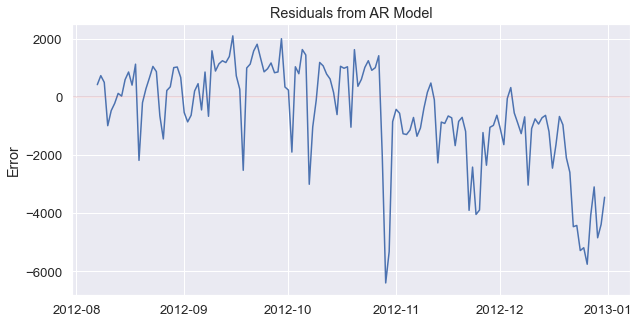

In [28]:
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title("Residuals from AR Model")
plt.ylabel("Error")
plt.axhline(0, color = 'r', alpha=0.2)
plt.show()

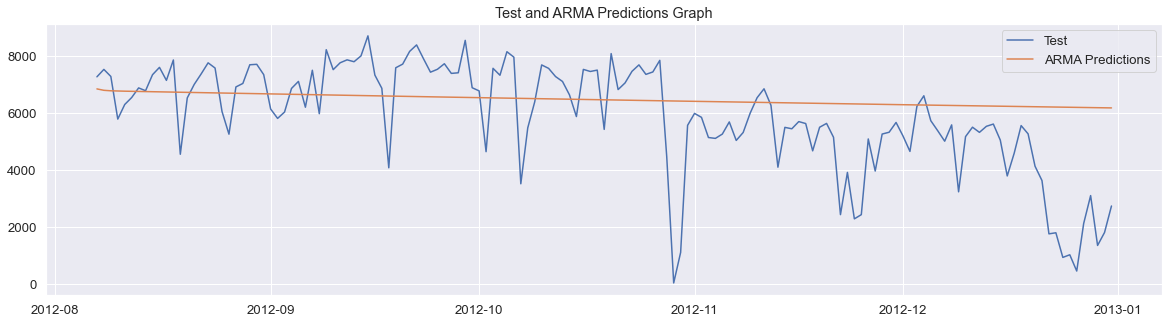

In [30]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(armapredictions)
plt.legend(["Test","ARMA Predictions"])
plt.title("Test and ARMA Predictions Graph")
plt.show()

In [31]:
mse = mean_squared_error(test, armapredictions)
mse

3445542.844080586

In [32]:
test.mean()

5897.802721088436

In [33]:
rmse = np.sqrt(mse)
rmse

1856.217348286721

In [34]:
armapredictions.mean()

6470.726931539099

### ARMA using AutoArima

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.info()

In [ ]:
df['cnt'] = df['cnt'].astype('float64')

In [ ]:
df.info()

In [ ]:
df.index.freq ='D'

In [ ]:
df.head()

In [ ]:
#auto_arima(df['cnt'],seasonal=False, start_p=1, start_q=1).summary()

In [ ]:
size = int(len(df)*0.8)

In [ ]:
size

In [ ]:
train, test = df.cnt[0:size], df.cnt[size:]

In [ ]:
train.head(), test.head()

In [ ]:
train.shape, test.shape

### ARIMA Model

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.head()

In [ ]:
df.index.freq ='D'

In [ ]:
arimamodel = ARIMA(train,order=(1,1,6))

In [ ]:
arimamodel_fit = arimamodel.fit()

In [ ]:
arimamodel_fit.summary()

In [ ]:
#residuals = arimamodel_fit.resid

In [ ]:
# residuals.plot(figsize=(20,5), title="Residuals")
# plt.show()

In [ ]:
#residuals.describe()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
start, end

In [ ]:
arimapredictions = arimamodel_fit.predict(start=start, end=end, typ='levels').rename("ARIMA Predictions")

In [ ]:
arimapredictions

In [ ]:
test

In [ ]:
test.plot(figsize=(20,5),legend=True)
arimapredictions.plot(legend=True)
plt.title("Test values versus ARIMA predictions")
plt.show()

In [ ]:
mse = mean_squared_error(test,arimapredictions)
mse

In [ ]:
error = rmse(test,arimapredictions)

In [ ]:
error

In [ ]:
test.mean()

### SARIMA Model

In [ ]:
df.head()

In [ ]:
df.index.freq = "D"

In [ ]:
sarimamodel = SARIMAX(endog=train, order=(1,1,1), seasonal_order=(1,1,1,12))

In [ ]:
sarimamodel_fit = sarimamodel.fit()

In [ ]:
sarimamodel_fit.summary()

In [ ]:
sarimamodel_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
start, end

In [ ]:
sarimapredictions = sarimamodel_fit.predict(start=start, end=end).rename("SARIMA Predictions")

In [ ]:
sarimapredictions

In [ ]:
test

In [ ]:
test.plot(figsize=(20,5),legend=True)
sarimapredictions.plot(legend=True)
plt.title("Test values versus SARIMA predictions")
plt.show()

In [ ]:
mse = mean_squared_error(test,sarimapredictions)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

### Auto-ARIMA

In [ ]:
df = pd.read_csv("bikeseries.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
df.index.freq ='D'

In [ ]:
df.head()

In [ ]:
stepwise_model = auto_arima(y=df["cnt"],exogenous=None,start_p=1,start_q=1,max_p=10,max_q=10,d=None,D=None,
                              start_P=0,start_Q=0,m=1,seasonal=True,suppress_warnings=True,stepwise=True,trace=True )

In [ ]:
print(stepwise_model.aic())

In [ ]:
train, test

In [ ]:
stepwise_model.fit(train)

In [ ]:
autopredict = stepwise_model.predict(147)

In [ ]:
autopredict

In [ ]:
autopredictdf = pd.DataFrame(autopredict, index=test.index, columns=["count"])

In [ ]:
autopredictdf

In [ ]:
test.plot(figsize=(20,5),legend=True)
autopredictdf.plot(legend=True)
plt.title("Test values versus AutoARIMA predictions")
plt.show()